In [1]:
%matplotlib inline
import sys
import numpy as np
import pystan
import scipy.io as sio
import time

# model 0: testing stan

In [27]:
t = time.time()
model_code = """
   data {
       int<lower=1> Nbins; // number of bins 
       vector[Nbins] x; // input
       real<lower=0> sigma; // standard deviation for normal
   }
   transformed data {
   }
   parameters {
       vector[Nbins] y; // output
   }  
   model {         
        y ~ normal(x,sigma);
   }
"""

datain = {'Nbins': 6,
        'x': [1,20,3,4,-1,3],
        'sigma': 2
       }

#sm = pystan.StanModel(model_code=model_code)
fit = pystan.stan(model_code=model_code, data=datain,
                  iter=1000, chains=4)

elapsed = time.time() - t
print(elapsed)

yextract = fit.extract('y')
temp = yextract["y"]
print(temp.shape)
op = sm.optimizing(data=datain)
op

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d318d729a5f7d61c571fb4e13264ef98 NOW.


33.51999497413635
(2000, 6)


OrderedDict([('y', array([  1.,  20.,   3.,   4.,  -1.,   3.]))])

# model 1: linear-circular regression in 1d with von mises noise

Our inputs are real values 

$$x_1,\dots,x_N,$$ 

and our outputs are circular variables

$$ y_1, \dots, y_N. $$

It's a bit of a hack (in the way that it's data-dependent), but for now we'll always assume that the output is shifted so that $y_1 = 0$ (need to understand if this actually changes the problem in any way? I don't think it should...)

Our model parameters will be 

$$\{\alpha,\beta\},$$ 

with the model being 

$$\left( y_i - \text{mod}(\alpha x_i, 2\pi) \right) \sim \text{von_mises}(0,\beta) $$

ie, $\alpha$ is the "slope," or frequency, and $\beta$ is the variance of the noise distribution.

I need to understand the following better in certain technical aspects, but:

to actually implement this without the "modulo," we do the following:

1. first map $x$ to the unit vector $\tilde{y} = (\cos(\alpha x),\sin(\alpha x))$
2. then define the residual $r = m_{y}^{-1} \tilde{y}$, where $m_{y}$ is the matrix representing rotation by $y$. 
3. now define $\theta_r = \text{acos}(r[1])$; then we simply require that $ r\sim \text{von_mises}(0,\beta)$. Note that the $\text{acos}$ throws away information about the residual as it never takes values between $-\pi$ and $0$; however this is OK because of the symmetry of the v.m. dist. around $0$.


In [85]:
Nbins = 20
x = 100*np.random.rand(Nbins,1)
alpha = 40
x = x - x.min()
y = np.mod(2*np.pi*x/alpha,2*np.pi)
y = np.column_stack((np.cos(y),np.sin(y)))
mu_beta = 0
sigma_beta = np.pi/4
mu_alpha = 40
sigma_alpha = 5
x = x.transpose()
x = x.squeeze()
datain = {
            'Nbins': Nbins,
            'x': x,
            'y': y,
            'mu_alpha': mu_alpha,
            'sigma_alpha': sigma_alpha,
            'mu_beta': mu_beta,
            'sigma_beta': sigma_beta,            
        }
initin = {
            'alpha': 40,
            'beta': np.pi/8,
        }
initin = [initin]
a = False
a

t = time.time()
mcode = """
    functions {
        vector rotate_xy(vector x, vector y) {
            // this function rotates vector y by -x (ie, minus the angle 
            // represented by x). for example, it gives [1;0] if x=y.         
            
            matrix[2, 2] m; // matrix representing rotation by -theta_x
            m[1, 1] = x[1];
            m[2, 1] = -x[2];
            m[1, 2] = x[2];
            m[2, 2] = x[1];        
            return m*y;        
        }        
    }
    data {
       int<lower=0> Nbins; // number of bins 
       vector[Nbins] x; // input variables
       unit_vector[2] y[Nbins]; // output variables 
       real<lower=0> mu_alpha;
       real<lower=0> sigma_alpha;
       real<lower=0> mu_beta;
       real<lower=0> sigma_beta;                     
    }
    transformed data {
        print(y);
    }
    parameters {
        real<lower=0> alpha; // frequency
        real<lower=0> beta; // variance
    }
    transformed parameters {
        unit_vector[2] ytilde[Nbins];
        unit_vector[2] temp;
        real<lower = -1, upper = 1> temp2;
        vector<lower = -pi(), upper = pi()>[Nbins] r;
        
        for (n in 1:Nbins) {
            temp[1] = cos(2*pi()*x[n]/alpha);
            temp[2] = sin(2*pi()*x[n]/alpha);
            ytilde[n] = temp;
            temp = rotate_xy(y[n],ytilde[n]);
            temp2 = temp[1];
            r[n] = acos(temp2);
         }  
         
         print(alpha);
         print(beta);
         print(r);
         print(y);
         print(ytilde);
    }          
    model {    
        alpha ~ normal(mu_alpha,sigma_alpha);
        beta ~ normal(mu_beta,sigma_beta);
        for (n in 1:Nbins) {
            // r[n] ~ von_mises(0,beta);
            r[n] ~ uniform(-beta,beta);
        }
    }
"""

# sm = pystan.StanModel(model_code=model_code)
# elapsed = time.time() - t
# print(elapsed)
# op = sm.optimizing(data=datain,init=initin,test_grad=True)

dstr = '/Users/samlewallen/Desktop/dfile'
#sm = pystan.StanModel(model_code=mcode)
#fit = sm.sampling(data=datain, chains=1, test_grad=True, init=initin, verbose=True,diagnostic_file=dstr)
fit = pystan.stan(model_code=mcode, data=datain, chains=1, init=initin, test_grad=True, diagnostic_file=dstr)

False

# model 1b

In [157]:
Nbins = 15
x = 100*np.random.rand(Nbins,1)
alpha = 45
# x = x - x.min()
x = x.squeeze()
y = np.mod(x/alpha,1)
datain = {
            'Nbins': Nbins,
            'x': x,
            'y': y,
        }
initin = {         
            'alpha': 30
        }
initin = [initin, initin, initin, initin]

t = time.time()
mcode = """
    data {
       int<lower=0> Nbins; // number of bins 
       vector[Nbins] x; // input variables
       vector[Nbins] y; // output variables        
    }
    transformed data {
        vector[Nbins] yx;
        vector[Nbins] yy;
        yx = cos(2*pi()*y);
        yy = sin(2*pi()*y);
    }
    parameters {
        real<lower = 25, upper = 50> alpha; // frequency        
    }
    transformed parameters {
        vector[Nbins] r;        
        for (n in 1:Nbins) {
            r[n] = (cos(2*pi()*x[n]/alpha) - yx[n])^2 + (sin(2*pi()*x[n]/alpha) - yy[n])^2;
        }   
        print(r);
    }         
    model {    
        //alpha ~ normal(40,10);
        alpha ~ uniform(25,50);
        r ~ normal(0,.25);
    }
"""

# elapsed = time.time() - t
# print(elapsed)
# op = sm.optimizing(data=datain,init=initin,test_grad=True)

#sm = pystan.StanModel(model_code=mcode)
#fit = sm.sampling(data=datain, chains=1, test_grad=True, init=initin, verbose=True)

#fit = pystan.stan(model_code=mcode, data=datain, chains=4, iter = 1000, test_grad=False, init=initin)
fit = pystan.stan(model_code=mcode, data=datain, chains=4, iter = 1000, test_grad=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9191dc334ce388d37ca1794a73dbb766 NOW.


In [160]:
fit.extract('alpha')

OrderedDict([('alpha',
              array([ 46.77131858,  46.37922515,  45.05326924, ...,  45.48554031,
                      45.12545954,  43.48643745]))])

# model 2: 1b in 2d

In [2]:
# IMPORT 2D DATA FROM MATLAB:

str = '/Users/samlewallen/Documents/neuroscience/MEC_2PCI_Yi_project/yi_david_shape_and_more/data_for_stan/com.mat'
mat_contents = sio.loadmat(str)
com = mat_contents['com']
str = '/Users/samlewallen/Documents/neuroscience/MEC_2PCI_Yi_project/yi_david_shape_and_more/data_for_stan/p01.mat'
mat_contents = sio.loadmat(str)
p01 = mat_contents['p01']
com = np.float64(com)
p01 = np.float64(p01)
Nbins = com.shape[1]
x = com
y = p01
datain = {
            'Nbins': Nbins,
            'x': x,
            'y': y,
        }
t = time.time()
mcode = """
    data {
       int<lower=0> Nbins; // number of bins 
       matrix[2, Nbins] x; // input variables
       matrix[2, Nbins] y; // output variables        
    }
    transformed data {
        matrix[2, 2] Hinv; // hexagonal basis
        matrix[2, Nbins] yx;
        matrix[2, Nbins] yy;
        yx = cos(2*pi()*y);
        yy = sin(2*pi()*y); 
        Hinv[1,1] = 1;
        Hinv[2,1] = 0;
        Hinv[1,2] = -sqrt(3)/3;
        Hinv[2,2] = 2*sqrt(3)/3;
    }
    parameters {
        real<lower = 100, upper = 300> alpha; // scale
        unit_vector[2] theta; // orientation (rotation)
    }
    transformed parameters {
        vector[Nbins] r; // residuals
        matrix[2,Nbins] xr;        
        matrix[2, 2] Rtheta; // rotation matrix (actually there's an inversion question)
        Rtheta[1,1] = theta[1];
        Rtheta[2,1] = theta[2];
        Rtheta[1,2] = -theta[2];
        Rtheta[2,2] = theta[1];        
        xr = 2*pi()*(1/alpha)*Hinv*Rtheta*x;        
        for (n in 1:Nbins) {
            r[n] = (cos(xr[1,n]) - yx[1,n])^2 + (sin(xr[1,n]) - yy[1,n])^2 + (cos(xr[2,n]) - yx[2,n])^2 + (sin(xr[2,n]) - yy[2,n])^2;
            }   
        // print(r);
    }         
    model {    
        alpha ~ uniform(100,300);
        r ~ normal(0,.1);
    }
"""
elapsed = time.time() - t
sm = pystan.StanModel(model_code=mcode)
print(elapsed)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7879c0225017e71e082f5fb3cde7596d NOW.


0.00015401840209960938


In [318]:
initin = {
            'alpha': 200
        }
initin = [initin]
op = sm.optimizing(data=datain,refresh=100,save_iterations=True,init=initin,algorithm='BFGS')
#fit = sm.sampling(data=datain, chains=1, test_grad=True, init=initin, verbose=True)
#fit = pystan.stan(model_code=mcode, data=datain, chains=4, iter = 1000, test_grad=False, init=initin)
#fit = pystan.stan(model_code=mcode, data=datain, chains=4, iter = 1000, test_grad=False)
op['alpha']
# op['theta']
# op['r']

array(261.03967740822316)

In [3]:
fit = sm.sampling(data=datain, chains=4, iter = 2000)

In [246]:
a = fit.extract('alpha')
aa = a['alpha']


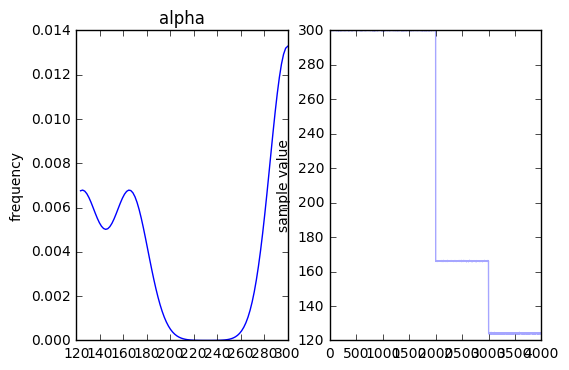

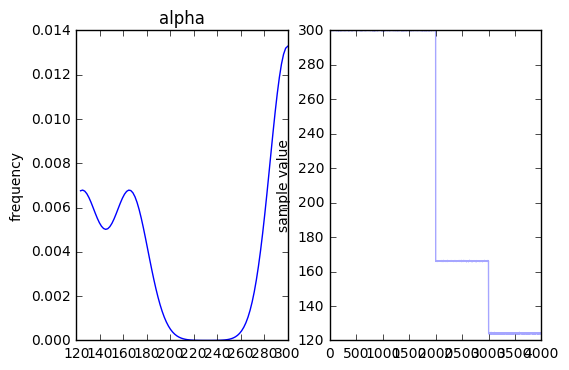

In [5]:
 fit.plot(pars=['alpha'])
#fit.plot(pars=['theta'])

# model 2: constant hexagonal lattice

- parameters are p (spacing) and theta (rotation) (both constant across brain)
- options for noise model:
    - von mises distribution with fixed variance

In [131]:
a = fit.extract('alpha')
i = fit.inits
i
a

OrderedDict([('alpha',
              array([ 44.50687355,  45.80762092,  45.96403622, ...,  44.04802205,
                      46.05153267,  45.80272129]))])

In [43]:
# Load data from matlab
str = '/Users/samlewallen/Documents/neuroscience/BRAIN_data_project/Nbins.mat'
mat_contents = sio.loadmat(str)
Nbins = mat_contents['Nbins']
str = '/Users/samlewallen/Documents/neuroscience/BRAIN_data_project/x.mat'
mat_contents = sio.loadmat(str)
x = mat_contents['x']
str = '/Users/samlewallen/Documents/neuroscience/BRAIN_data_project/y.mat'
mat_contents = sio.loadmat(str)
y = mat_contents['y']
x = np.float64(x)
y = np.float64(y)
Nbins = np.int(Nbins)
x = x.transpose()
y = y.transpose()
x = x.squeeze()
y = y.squeeze()

x.transpose

<function ndarray.transpose>

In [105]:
t = time.time()
ocode = """
   data {
       int<lower=1> Nbins; // number of bins 
       vector[Nbins] x; // position bins 
       vector[Nbins] y; // data 
   }
   transformed data {
       int<lower=1> Nbumps; // number of bumps to consider % for now, hard-coded   
        real<lower=0> sigmaSqGP;
        real<lower=0> etaSqGP;
        real<lower=0> rhoSqGP;
        Nbumps = 5; 
        sigmaSqGP = .01;
        etaSqGP = .01;
        rhoSqGP = 1;
   }
   parameters {
       simplex[Nbumps] lambda; // scaled "bump domains" 
       vector<lower=0>[Nbumps] bumpSigma; // bump widths 
       vector<lower=0>[Nbumps] bumpHeight; // bump heights
       // real<lower=0> sigmaSqGP; 
       // real<lower=0> etaSqGP; 
       // real<lower=0> rhoSqGP; 
   }  
   transformed parameters {
       vector<lower=x[1],upper=x[Nbins]>[Nbumps] bumpCtrs; // bump centers 
       vector<lower=x[1],upper=x[Nbins]>[Nbumps] bumpDomainLengths; 
       bumpDomainLengths = (x[Nbins] - x[1])*lambda;  
       bumpCtrs[1] = .5*bumpDomainLengths[1];    
       for (n in 2:Nbumps)
         bumpCtrs[n] = bumpCtrs[n-1] + .5*bumpDomainLengths[n-1] + .5*bumpDomainLengths[n]; 
   }
   model {         
       vector[Nbins] mu; 
       matrix[Nbins,Nbins] Sigma; 
       vector[Nbumps] alpha; 
       for (i in 1:Nbumps) 
         alpha[i] = 3;
   
      // compute GP mean mu: 
       mu = 0*y;   
       for (n in 1:Nbumps)
         mu = mu + bumpHeight[n] * exp( -( x-bumpCtrs[n]).*(x-bumpCtrs[n] ) / (2*bumpSigma[n]^2) ); 
   
      // compute GP cov Sigma:    
      // off-diagonal elements 
       for (i in 1:(Nbins-1)) { 
         for (j in (i+1):Nbins) { 
           Sigma[i, j] = etaSqGP * exp(-rhoSqGP * pow(x[i] - x[j],2)); 
           Sigma[j, i] = Sigma[i, j]; 
          } 
       } 
      // diagonal elements 
       for (k in 1:Nbins)  
           Sigma[k, k] = etaSqGP + sigmaSqGP;  // + jitter 
   
      // models and priors: 
       lambda ~ dirichlet(alpha); 
       for (i in 1:Nbumps) 
           bumpSigma[i] ~ normal(8,3); 
       for (i in 1:Nbumps) 
           bumpHeight[i] ~ normal(1,.3); 
       // etaSqGP ~ cauchy(0, .1); 
       // rhoSqGP ~ cauchy(0, 1); 
       // sigmaSqGP ~ cauchy(0, .1); 
   
      // process: 
       y ~ multi_normal(mu, Sigma); 
   }
"""
sm = pystan.StanModel(model_code=ocode)
elapsed = time.time() - t
print(elapsed)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d1ec03d0e40de3dc4d5c71af6f4d73a NOW.


30.511999130249023


In [68]:
datain = {'x': x,
        'y': y,
        'Nbins': Nbins
       }
op = sm.optimizing(data=datain)
str = '/Users/samlewallen/Documents/neuroscience/BRAIN_data_project/map.mat'
sio.savemat(str,op)

In [109]:
t = time.time()
fit = sm.sampling(data=datain,iter=2000, chains=2)
elapsed = time.time() - t
str = '/Users/samlewallen/Documents/neuroscience/BRAIN_data_project/fit.mat'
sio.savemat(str,fit.extract())
print(elapsed)
fit

36.807563066482544


Inference for Stan model: anon_model_5d1ec03d0e40de3dc4d5c71af6f4d73a.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]              0.26    0.15   0.15   0.06   0.11   0.28   0.41   0.42      1   9.98
lambda[1]              0.24    0.05   0.05   0.13   0.19   0.26   0.27    0.3      1   1.57
lambda[2]              0.29    0.19   0.19   0.06    0.1   0.26   0.48   0.55      1   6.35
lambda[3]              0.13  4.9e-3   0.04   0.05   0.11   0.13   0.15    0.2     60   1.04
lambda[4]               0.1  2.5e-3   0.02   0.06   0.09    0.1   0.11   0.14     70   1.03
bumpSigma[0]           6.96    3.84   3.84   0.51   2.82   8.07   9.97  13.32      1   1.63
bumpSigma[1]          11.09    1.44   2.04   7.27   9.55  11.16  12.53  14.98      2   1.35
bumpSigma[2]           7.47    5.55   5.55   0.16   1.48   9.88  12.58  15.

In [108]:
fit.extract('bumpHeight')

OrderedDict([('bumpHeight',
              array([[ 0.93003183,  1.06907211,  1.33177389,  0.33392324,  0.31640749],
                     [ 0.93785883,  1.20738098,  0.67972548,  0.61116771,  0.76595339],
                     [ 0.80772965,  1.10899196,  0.8953727 ,  0.40598797,  1.38987105],
                     ..., 
                     [ 1.49481265,  0.81634302,  1.05731252,  0.30569385,  0.54227119],
                     [ 1.4696026 ,  0.80443629,  1.22259213,  0.45043697,  0.86776437],
                     [ 0.85852891,  0.7521639 ,  1.06925778,  0.17787774,  1.07541832]]))])

In [98]:
fit

Inference for Stan model: anon_model_708d9d0d02e5020b135942ec27793dbf.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]              0.05  2.2e-3   0.01   0.03   0.05   0.06   0.06   0.07     25   1.03
lambda[1]              0.03  2.4e-3   0.01   0.01   0.02   0.03   0.04   0.07     27   1.05
lambda[2]              0.91  4.7e-4 5.3e-3    0.9   0.91   0.91   0.92   0.92    130   1.02
bumpSigma[0]           2.51    0.41   2.52   0.35   1.06    1.7   2.53  10.35     38   1.01
bumpSigma[1]           3.95    0.75   3.51   0.03   1.34   2.79   5.91  12.66     22   1.11
bumpSigma[2]          12.62    0.16   1.57   9.57  11.41  12.57  13.82  15.69     96   1.02
bumpHeight[0]           0.8    0.05   0.39   0.14   0.49   0.84    1.1   1.47     55   1.01
bumpHeight[1]          0.73    0.06   0.38   0.17   0.38   0.75   1.02   1.44 